In [1]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd

# Load your CSV files

clients_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_clients_naics_mask.csv")
workers_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_workers_label_encoded_student.csv")
payments_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_payments.csv")
products_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_products.csv")

In [14]:
import networkx as nx

# Create a new graph
G = nx.Graph()

# Add client nodes
for idx, row in clients_df.iterrows():
    client_id = str(int(row['Client_Id']))  # Convert to string and remove any decimal places
    G.add_node(f"Client_{client_id}", type='client', **row.to_dict())

# Add worker nodes
for idx, row in workers_df.iterrows():
    worker_id = str(row['Worker_ID'])
    G.add_node(f"Worker_{worker_id}", type='worker', **row.to_dict())

# Add product nodes (assuming unique product groups across clients)
for idx, row in products_df.drop_duplicates(subset=['product_group']).iterrows():
    product_group = str(row['product_group'])
    G.add_node(f"Product_{product_group}", type='product', **row.to_dict())

# Add edges for worker-client relationships
for idx, row in workers_df.iterrows():
    worker_id = str(row['Worker_ID'])
    client_id = str(int(row['Client_Id']))  # Convert to string and remove any decimal places
    G.add_edge(f"Worker_{worker_id}", f"Client_{client_id}", type='works_for')

# Add edges for client-product relationships
for idx, row in products_df.iterrows():
    client_id = str(int(row['Client_Id']))  # Convert to string and remove any decimal places
    product_group = str(row['product_group'])
    G.add_edge(f"Client_{client_id}", f"Product_{product_group}", type='purchased')

# Optionally, add payment information as edge attributes between workers and clients
for idx, row in payments_df.iterrows():
    worker_id = str(row['Worker_ID'])
    client_id = str(int(row['Client_Id']))  # Convert to string and remove any decimal places
    # Ensure the edge exists before setting attributes
    if G.has_edge(f"Worker_{worker_id}", f"Client_{client_id}"):
        G[f"Worker_{worker_id}"][f"Client_{client_id}"]['payment_type'] = row['payment_type']
        G[f"Worker_{worker_id}"][f"Client_{client_id}"]['payment_amount'] = row['payment_amount']


KeyboardInterrupt: 

In [ ]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


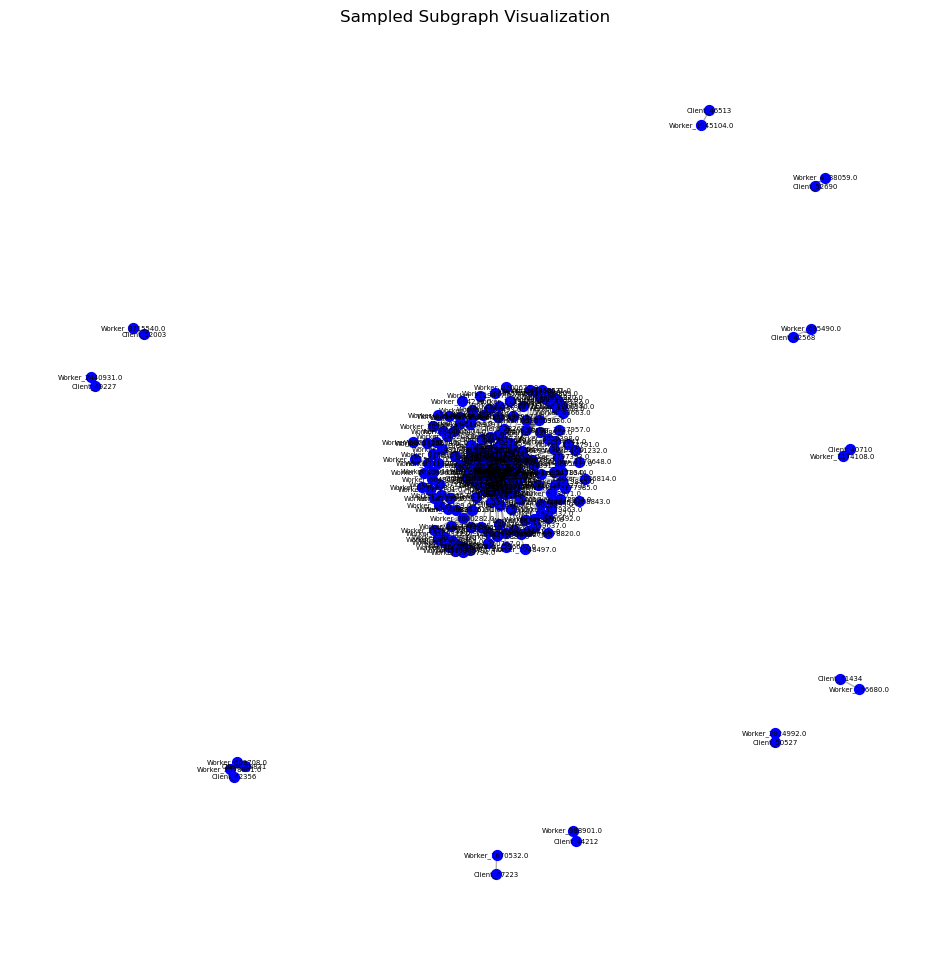

In [12]:
import matplotlib.pyplot as plt
import networkx as nx
import random

# Convert G.nodes() to a list for random sampling
node_list = list(G.nodes())

# Sample 100 random nodes (if there are enough nodes)
sample_size = min(100, len(node_list))
sampled_nodes = random.sample(node_list, sample_size)

# Create a subgraph with these nodes
subgraph = G.subgraph(sampled_nodes)

# To include the immediate neighbors, create an extended subgraph
extended_subgraph_nodes = set(sampled_nodes)
for node in sampled_nodes:
    extended_subgraph_nodes.update(G.neighbors(node))

# Create the extended subgraph
extended_subgraph = G.subgraph(extended_subgraph_nodes)

# Now let's visualize the extended subgraph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(extended_subgraph)

# Draw nodes
nx.draw_networkx_nodes(extended_subgraph, pos, node_size=50, node_color='blue')

# Draw edges
nx.draw_networkx_edges(extended_subgraph, pos, alpha=0.3)

# Draw node labels
nx.draw_networkx_labels(extended_subgraph, pos, font_size=5, font_color='black')

plt.title('Sampled Subgraph Visualization')
plt.axis('off')  # Turn off the axis
plt.show()


In [ ]:
# Assuming you have already created a graph `G` and have nodes for workers and job titles...

# Read the mapping file into a pandas DataFrame
majors_df = pd.read_csv('majors_dictionary_student.csv')

# Create a lookup dictionary from the DataFrame
oe_ws_major_to_paychex_code = pd.Series(majors_df.Paychex_Code.values, index=majors_df.OEWS_Major).to_dict()

# Add the OEWS_Major as an attribute to the worker nodes (if applicable)
for idx, row in workers_df.iterrows():
    worker_node_id = f"Worker_{row['Worker_ID']}"
    if worker_node_id in G:
        # Here 'OEWS_Code_1' is assumed to be a column in your worker dataset representing the Paychex_Code
        oe_ws_major = oe_ws_major_to_paychex_code.get(row['OEWS_Code_1'])
        if oe_ws_major:
            G.nodes[worker_node_id]['OEWS_Major'] = oe_ws_major


In [47]:
import networkx as nx
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader

# Define the GNN model
class GNNPredictor(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GNNPredictor, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Load data from DataFrame
def load_data(clients_df, workers_df, products_df, payments_df):
    G = nx.Graph()

    # Add client nodes
    for idx, row in clients_df.iterrows():
        client_id = str(int(row['Client_Id']))
        G.add_node(f"Client_{client_id}", type='client', **row.to_dict())

    # Add worker nodes
    for idx, row in workers_df.iterrows():
        worker_id = str(row['Worker_ID'])
        G.add_node(f"Worker_{worker_id}", type='worker', **row.to_dict())

    # Add product nodes (assuming unique product groups across clients)
    for idx, row in products_df.drop_duplicates(subset=['product_group']).iterrows():
        product_group = str(row['product_group'])
        G.add_node(f"Product_{product_group}", type='product', **row.to_dict())

    # Add edges for worker-client relationships
    for idx, row in workers_df.iterrows():
        worker_id = str(row['Worker_ID'])
        client_id = str(int(row['Client_Id']))
        G.add_edge(f"Worker_{worker_id}", f"Client_{client_id}", type='works_for')

    # Add edges for client-product relationships
    for idx, row in products_df.iterrows():
        client_id = str(int(row['Client_Id']))
        product_group = str(row['product_group'])
        G.add_edge(f"Client_{client_id}", f"Product_{product_group}", type='purchased')

    # Optionally, add payment information as edge attributes between workers and clients
    for idx, row in payments_df.iterrows():
        worker_id = str(row['Worker_ID'])
        client_id = str(int(row['Client_Id']))
        if G.has_edge(f"Worker_{worker_id}", f"Client_{client_id}"):
            G[f"Worker_{worker_id}"][f"Client_{client_id}"]['payment_type'] = row['payment_type']
            G[f"Worker_{worker_id}"][f"Client_{client_id}"]['payment_amount'] = row['payment_amount']

    return G

# Convert NetworkX graph to PyTorch Geometric data
def nx_to_pyg(G):
    x = []
    edge_index = []
    edge_attr = []
    
    # Iterate over nodes and edges to collect attributes
    for node in G.nodes(data=True):
        x.append(list(node[1].values()))
    
    for edge in G.edges(data=True):
        edge_index.append([edge[0], edge[1]])
        edge_attr.append(list(edge[2].values()))
    for i in range(len(x)):
        for j in range(len(x[i])):
            if isinstance(x[i][j], (int, float)):
                x[i][j] = int(x[i][j])
    # Convert attributes to tensors
    x = torch.tensor(x, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float).squeeze()
    
    # Create PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    
    return data

# Load datasets from CSV files

clients_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_clients_naics_mask.csv", nrows=20)
workers_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_workers_label_encoded_student.csv", nrows=20)
payments_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_payments.csv", nrows=20)
products_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_products.csv", nrows=20)

# Convert 'Client_Id' column in clients_df to integer

clients_df.fillna(0, inplace=True)
clients_df = clients_df.astype(int)


# Convert 'Worker_ID' column in workers_df to integer
workers_df.fillna(0, inplace=True)
workers_df = workers_df.drop(columns = 'predicted').astype(int)


products_df.fillna(0, inplace=True)
products_df = products_df.astype(int)

payments_df.fillna(0, inplace=True)
payments_df = payments_df.astype(int)


# Load data into NetworkX graph
G = load_data(clients_df, workers_df, products_df, payments_df)

# Convert NetworkX graph to PyTorch Geometric data
data = nx_to_pyg(G)

# Define model parameters
num_features = len(clients_df.columns) + len(workers_df.columns) + len(products_df.columns)
hidden_dim = 64
num_classes = 2  # Modify based on your prediction task

# Initialize the model
model = GNNPredictor(num_features, hidden_dim, num_classes)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Train-test split
# Replace this with your own method of splitting data into train and test sets

# Create data loader
train_loader = DataLoader([data], batch_size=32, shuffle=True)

# Initialize the model, optimizer, and loss function
model = GCN(input_dim=features_train.shape[1], hidden_dim=64, output_dim=2)  # Binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(epochs):
    for batch_data in train_loader:
        optimizer.zero_grad()
        out = model(batch_data)
        loss = criterion(out, labels_train)
        loss.backward()
        optimizer.step()

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(features_test, edge_index)
    pred_labels = logits.argmax(dim=1)
    accuracy = (pred_labels == labels_test).sum().item() / len(labels_test)
    print(f'Test Accuracy: {accuracy}')

ValueError: too many dimensions 'str'

In [22]:
import pandas as pd
clients_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_clients_naics_mask.csv")
workers_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_workers_label_encoded_student.csv")
payments_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_payments.csv")
products_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_products.csv")

columns_to_drop = ['Worker_ID','predicted', 'Ethnicity', 'Officer_Type']
workers_df.drop(columns=columns_to_drop, inplace=True)
workers_df.fillna(value=-1, inplace=True)

# n = 1000
# workers_df = workers_df.sample(n=n)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


features = ['Worker_ID', 'Gender', 'Ethnicity', 'Officer_Type', 'Salary_Ind',
            'Work_Category_Type', 'Work_Benefit_type', 'Age', 'Client_Id', 'predicted',
            'OEWS_Code_2', 'OEWS_Code_3']
target = 'OEWS_Code_1'


# Define features and target variable
X = workers_df.drop(columns=['OEWS_Code_1'])  # Features
y = workers_df['OEWS_Code_1']  # Target variable

n = 1000
X = X.head(n)
y = y.head(n)

# categorical_features = X.select_dtypes(include=['object']).columns.tolist()
# transformers = [('one_hot_encoder', OneHotEncoder(), categorical_features)]
# preprocessor = ColumnTransformer(transformers, remainder='passthrough')
# X_encoded = preprocessor.fit_transform(X)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create and train Random Forest classifier
clf = RandomForestClassifier(n_estimators = 100,criterion = 'gini')
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


ValueError: could not convert string to float: 'Y'

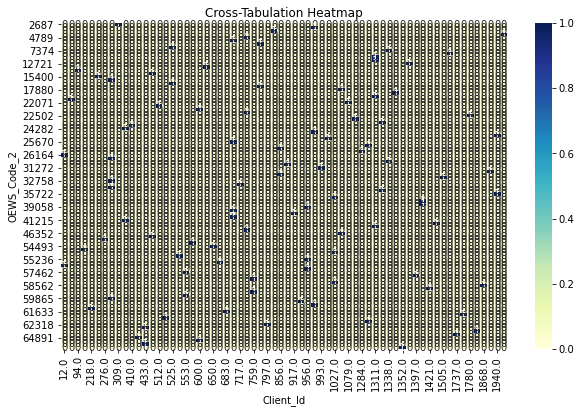

In [114]:
import researchpy as rp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


n = 100  # Specify the number of rows you want to select
workers_df = workers_df.sample(n=n)

categorical_columns = workers_df.select_dtypes(include=['object'])

# Create a cross-tabulation for multiple columns
cross_tab = pd.crosstab(index=[workers_df['Client_Id']], columns=workers_df['OEWS_Code_1'])

# # Display the cross-tabulation
# print("Cross-Tabulation:")
# print(cross_tab)

# Assuming cross_tab is your cross-tabulation DataFrame
# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='YlGnBu', fmt='d')  # Adjust the parameters as needed
plt.title('Cross-Tabulation Heatmap')
plt.xlabel('Client_Id')
plt.ylabel('OEWS_Code_2')
plt.show()


In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Sample data
# Assume workers_df is your DataFrame with features and target variable

target = 'OEWS_Code_1'

X = workers_df.drop(columns=[target])  # Features
y = workers_df[target]

n = 10000
X = X.head(n)
y = y.head(n)

# One-hot encode categorical features
X_encoded = pd.get_dummies(X)

# One-hot encode target variable
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2)

# Build the neural network model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(850, activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predict on the test set
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred)
print("Accuracy:", accuracy)


C:\Users\ahmad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [5]:
pip install numpy==1.24.3


Note: you may need to restart the kernel to use updated packages.


In [55]:
y_pred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [1]:
import pandas as pd

clients_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_clients_naics_mask.csv")
workers_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_workers_label_encoded_student.csv")
payments_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_payments.csv")
products_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_products.csv")

columns_to_drop = ['Worker_ID','predicted', 'Ethnicity', 'Officer_Type']
workers_df.drop(columns=columns_to_drop, inplace=True)
workers_df.fillna(value=-1, inplace=True)
# Sample data

In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.optimizers import Adam


# Assume workers_df is your DataFrame with features and target variable

target = 'OEWS_Code_1'

X = workers_df.drop(columns=[target])  # Features
y = workers_df[target]

n = 10000
X = X.sample(n=n, random_state=42)
y = y.sample(n=n, random_state=42)


# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode target variable
encoder = OneHotEncoder(categories='auto', sparse=False)
y_encoded = encoder.fit_transform(y_encoded.reshape(-1, 1))

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2)

# Build the neural network model
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(744, activation='softmax'))  # Output layer with softmax activation for multi-class classification


learning_rate = 0.0001  # Choose your desired learning rate

# Create the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Predict on the test set
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred)
print("Accuracy:", accuracy)


C:\Users\ahmad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


MemoryError: Unable to allocate 114. MiB for an array with shape (20000, 744) and data type float64

In [26]:
y_test.reset_index(drop=True, inplace=True)


In [38]:
y_test

0       1816.0
1       1421.0
2       1253.0
3        543.0
4         64.0
         ...  
1995     112.0
1996     734.0
1997    1723.0
1998    1145.0
1999     553.0
Name: OEWS_Code_1, Length: 2000, dtype: float64

In [42]:
print(y_pred)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [44]:
y

0       1342.0
1       1342.0
2       1342.0
3       1342.0
4       1342.0
         ...  
9995     842.0
9996     990.0
9997    1544.0
9998     657.0
9999     553.0
Name: OEWS_Code_1, Length: 10000, dtype: float64

In [63]:
y_train

8685    1169.0
9696     553.0
3277     960.0
9027    1311.0
6976    1094.0
         ...  
6576     498.0
4205     306.0
2688     990.0
7536     546.0
1129     657.0
Name: OEWS_Code_1, Length: 8000, dtype: float64

In [76]:
# ______________________________________________________________________--

In [2]:
import pandas as pd

# Load your CSV files

clients_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_clients_naics_mask.csv")
workers_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_workers_label_encoded_student.csv")
payments_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_payments.csv")
products_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_products.csv")

In [5]:
import pandas as pd
import os

# Load your CSV files
clients_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_clients_naics_mask.csv")
workers_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_workers_label_encoded_student.csv")
payments_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_payments.csv")
products_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_products.csv")

# Get random subset of 100 rows for each DataFrame
clients_subset = clients_df.sample(n=100)  # You can change the random_state for different random samples
workers_subset = workers_df.sample(n=100)
payments_subset = payments_df.sample(n=100)
products_subset = products_df.sample(n=100)

output_dir = r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\subsampled_files"

# Write subsets to CSV files with modified names
clients_subset.to_csv(os.path.join(output_dir, "clients_subset.csv"), index=False)
workers_subset.to_csv(os.path.join(output_dir, "workers_subset.csv"), index=False)
payments_subset.to_csv(os.path.join(output_dir, "payments_subset.csv"), index=False)
products_subset.to_csv(os.path.join(output_dir, "products_subset.csv"), index=False)

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load your CSV files
clients_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_clients_naics_mask.csv")
workers_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_workers_label_encoded_student.csv")
payments_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_payments.csv")
products_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_products.csv")

# Create a dictionary to store DataFrames
dfs = {
    'clients_df': clients_df,
    'workers_df': workers_df,
    'payments_df': payments_df,
    'products_df': products_df
}

# Create a graph
G = nx.Graph()

# Add nodes representing DataFrames
for df_name in dfs:
    G.add_node(df_name)

# Add edges representing linked columns
for df_name1, df1 in dfs.items():
    for df_name2, df2 in dfs.items():
        if df_name1 != df_name2:  # Exclude self-loops
            linked_columns = set(df1.columns) & set(df2.columns)
            if linked_columns:
                G.add_edge(df_name1, df_name2, columns=', '.join(linked_columns))

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color='skyblue', font_size=10, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'columns')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# Show the plot
plt.title('DataFrames and Linked Columns')
plt.show()


NetworkXError: random_state_index is incorrect

<Figure size 720x576 with 0 Axes>

In [12]:
workers_df

,Worker_ID,Gender,Ethnicity,Officer_Type,Salary_Ind,Work_Category_Type,Work_Benefit_type,Age,Client_Id,predicted,OEWS_Code_1,OEWS_Code_2,OEWS_Code_3
0,2958714.0,1.0,NaN,NaN,1.0,0.0,1.0,4.0,0,Y,1342.0,1155.0,775.0
1,2958715.0,1.0,NaN,NaN,1.0,0.0,1.0,4.0,0,Y,1342.0,1155.0,1970.0
2,2958716.0,1.0,NaN,NaN,1.0,0.0,1.0,4.0,0,Y,1342.0,1333.0,657.0
3,2958717.0,1.0,NaN,NaN,1.0,0.0,1.0,4.0,0,Y,1342.0,1155.0,775.0
4,2958718.0,1.0,NaN,NaN,1.0,0.0,1.0,4.0,0,Y,1342.0,775.0,1970.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4226512,4080013.0,1.0,NaN,NaN,0.0,NaN,1.0,4.0,67277,Y,1299.0,1954.0,1714.0
4226513,4080026.0,1.0,NaN,NaN,0.0,NaN,1.0,3.0,67277,Y,670.0,871.0,1984.0
4226514,4080029.0,1.0,NaN,NaN,0.0,NaN,1.0,3.0,67277,Y,1288.0,1397.0,1825.0
4226515,4080035.0,1.0,NaN,NaN,0.0,NaN,1.0,3.0,67277,Y,1288.0,1397.0,1048.0


In [17]:
# Assuming 'predicted' is the column name in workers_df
filtered_workers_df = workers_df[workers_df['predicted'] == 'Y']
count = len(filtered_workers_df)
print("Number of Predicted Labels:", count)


Number of Predicted Labels: 3776983


In [14]:
filtered_workers_df

,Worker_ID,Gender,Ethnicity,Officer_Type,Salary_Ind,Work_Category_Type,Work_Benefit_type,Age,Client_Id,predicted,OEWS_Code_1,OEWS_Code_2,OEWS_Code_3
0,2958714.0,1.0,NaN,NaN,1.0,0.0,1.0,4.0,0,Y,1342.0,1155.0,775.0
1,2958715.0,1.0,NaN,NaN,1.0,0.0,1.0,4.0,0,Y,1342.0,1155.0,1970.0
2,2958716.0,1.0,NaN,NaN,1.0,0.0,1.0,4.0,0,Y,1342.0,1333.0,657.0
3,2958717.0,1.0,NaN,NaN,1.0,0.0,1.0,4.0,0,Y,1342.0,1155.0,775.0
4,2958718.0,1.0,NaN,NaN,1.0,0.0,1.0,4.0,0,Y,1342.0,775.0,1970.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4226512,4080013.0,1.0,NaN,NaN,0.0,NaN,1.0,4.0,67277,Y,1299.0,1954.0,1714.0
4226513,4080026.0,1.0,NaN,NaN,0.0,NaN,1.0,3.0,67277,Y,670.0,871.0,1984.0
4226514,4080029.0,1.0,NaN,NaN,0.0,NaN,1.0,3.0,67277,Y,1288.0,1397.0,1825.0
4226515,4080035.0,1.0,NaN,NaN,0.0,NaN,1.0,3.0,67277,Y,1288.0,1397.0,1048.0


In [2]:
# _______________________________

In [2]:
import pandas as pd

clients_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_clients_naics_mask.csv")
workers_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_workers_label_encoded_student.csv")
payments_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_payments.csv")
products_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_products.csv")

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
import numpy as np
from sklearn.metrics import accuracy_score

merged_df = pd.merge(workers_df, payments_df, on=['Client_Id', 'Worker_ID'], how='left')

merged_df.drop_duplicates(subset='Worker_ID', keep='first', inplace=True)

# Define the file path
file_path = r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\merged_df.csv"

# Write merged_df to a CSV file
merged_df.to_csv(file_path, index=False)

print(f"DataFrame has been successfully written to {file_path}")


DataFrame has been successfully written to C:\Users\ahmad\Desktop\Team_07_Paychex-selected\merged_df.csv


In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.optimizers import Adam

file_path = r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\merged_df.csv"

# Load the dataset
merged_df = pd.read_csv(file_path)

# Sample the dataset
merged_df = merged_df.sample(n=10000, random_state=42)

# Drop specified columns
columns_to_drop = ['Worker_ID', 'predicted', 'Ethnicity', 'Officer_Type']
merged_df.drop(columns=columns_to_drop, inplace=True)

# Fill missing values with -1
merged_df.fillna(value=-1, inplace=True)

target = 'OEWS_Code_1'

X = merged_df.drop(columns=[target])  # Features
y = merged_df[target]

# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode target variable
encoder = OneHotEncoder(categories='auto', sparse=False)
y_encoded = encoder.fit_transform(y_encoded.reshape(-1, 1))

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2)

# Build the neural network model
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(568, activation='softmax'))  # Output layer with softmax activation for multi-class classification

learning_rate = 0.001  # Choose your desired learning rate

# Create the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Predict on the test set
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred)
print("Accuracy:", accuracy)

# Plot training accuracy over iterations
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1/100


C:\Users\ahmad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


250/250 [==============================] - 4s 15ms/step - loss: 548.3586 - accuracy: 0.0082
Epoch 2/100
250/250 [==============================] - 3s 13ms/step - loss: 6.2033 - accuracy: 0.0417
Epoch 3/100
250/250 [==============================] - 3s 13ms/step - loss: 6.2100 - accuracy: 0.0406
Epoch 4/100
250/250 [==============================] - 3s 13ms/step - loss: 6.0321 - accuracy: 0.0441
Epoch 5/100
250/250 [==============================] - 3s 13ms/step - loss: 5.9268 - accuracy: 0.0455
Epoch 6/100
250/250 [==============================] - 3s 13ms/step - loss: 5.8609 - accuracy: 0.0451
Epoch 7/100
250/250 [==============================] - 4s 14ms/step - loss: 5.7807 - accuracy: 0.0450
Epoch 8/100
250/250 [==============================] - 4s 15ms/step - loss: 5.8073 - accuracy: 0.0457
Epoch 9/100
250/250 [==============================] - 3s 14ms/step - loss: 5.6492 - accuracy: 0.0454
Epoch 10/100
250/250 [==============================] - 3s 14ms/step - loss: 5.5924 - accura

KeyboardInterrupt: 

In [11]:
import pandas as pd

clients_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_clients_naics_mask.csv")
workers_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_workers_label_encoded_student.csv")
payments_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_payments.csv")
products_df = pd.read_csv(r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\encoded_products.csv")

columns_to_drop = ['Worker_ID','predicted', 'Ethnicity', 'Officer_Type']
workers_df.drop(columns=columns_to_drop, inplace=True)
workers_df.fillna(value=-1, inplace=True)
# Sample data
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.optimizers import Adam


# Assume workers_df is your DataFrame with features and target variable

target = 'OEWS_Code_1'

X = workers_df.drop(columns=[target])  # Features
y = workers_df[target]

n = 10000
X = X.sample(n=n, random_state=42)
y = y.sample(n=n, random_state=42)


# # Label encode the target variable
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # One-hot encode target variable
# encoder = OneHotEncoder(categories='auto', sparse=False)
# y_encoded = encoder.fit_transform(y_encoded.reshape(-1, 1))

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2)

# Build the neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(568, activation='softmax'))  # Output layer with softmax activation for multi-class classification


learning_rate = 0.001  # Choose your desired learning rate

# Create the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Predict on the test set
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred)
print("Accuracy:", accuracy)


Epoch 1/100
250/250 [==============================] - 1s 3ms/step - loss: 420.2549 - accuracy: 0.0086
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 6.4236 - accuracy: 0.0310
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 6.1846 - accuracy: 0.0444
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 6.0552 - accuracy: 0.0449
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 5.9516 - accuracy: 0.0464
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 5.8542 - accuracy: 0.0469
Epoch 7/100
250/250 [==============================] - 1s 3ms/step - loss: 5.7914 - accuracy: 0.0476
Epoch 8/100
250/250 [==============================] - 1s 4ms/step - loss: 5.7197 - accuracy: 0.0472
Epoch 9/100
250/250 [==============================] - 1s 3ms/step - loss: 5.6621 - accuracy: 0.0471
Epoch 10/100
250/250 [==============================] - 1s 3ms/step - loss: 5.6060 - accu

KeyError: 'val_accuracy'

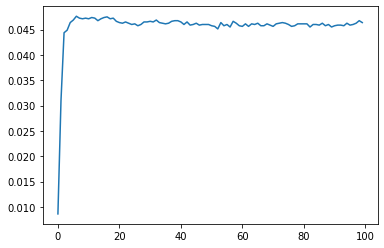

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

file_path = r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\merged_df.csv"

# Load the dataset
merged_df = pd.read_csv(file_path)

# Sample the dataset
merged_df = merged_df.sample(n=10000, random_state=42)

# Drop specified columns and 'Worker_ID'
columns_to_drop = ['Worker_ID', 'predicted', 'Gender', 'Ethnicity', 'Officer_Type']
merged_df.drop(columns=columns_to_drop, axis=1, inplace=True)

# Drop NaN values
merged_df.dropna(inplace=True)

# Define features (X) and target (y)
X = merged_df.drop('OEWS_Code_1', axis=1)
y = merged_df['OEWS_Code_1']

# Separate categorical and continuous features
categorical_features = [col for col in X.columns if col != 'payment_amount']
continuous_features = ['payment_amount']

# Convert categorical features to strings
X[categorical_features] = X[categorical_features].astype(str)

# One-hot encode categorical features
encoder = OneHotEncoder(drop='first', sparse=False)
X_categorical = encoder.fit_transform(X[categorical_features])

# Combine one-hot encoded features with continuous features
X_encoded = pd.concat([pd.DataFrame(X_categorical), X[continuous_features].reset_index(drop=True)], axis=1)

# Convert to arrays to drop feature names
X_encoded_array = X_encoded.values
y_array = y.values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded_array, y_array, test_size=0.2, random_state=42)

# Initialize the SVM classifier model
svm_model = SVC(kernel='rbf', random_state=42)

# Fit the model on the training data
svm_model.fit(X_train, y_train)

# Predict on the test data
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the SVM classifier model:", accuracy)


C:\Users\ahmad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy of the SVM classifier model: 0.0366116295764537


C:\Users\ahmad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\ahmad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\ahmad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\ahmad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. 

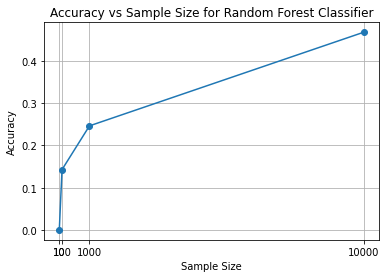

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


file_path = r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\merged_df.csv"

# Load the dataset
merged_df = pd.read_csv(file_path)

# Define sample sizes
sample_sizes = [10, 100, 1000, 10000]
accuracies = []

for sample_size in sample_sizes:
    # Sample the dataset
    sampled_df = merged_df.sample(n=sample_size, random_state=42)

    # Drop specified columns and 'Worker_ID'
    columns_to_drop = ['Worker_ID', 'predicted', 'Gender', 'Ethnicity', 'Officer_Type']
    sampled_df.drop(columns=columns_to_drop, axis=1, inplace=True)

    # Drop NaN values
    sampled_df.dropna(inplace=True)

    # Define features (X) and target (y)
    X = sampled_df.drop('OEWS_Code_1', axis=1)
    y = sampled_df['OEWS_Code_1']

    # Separate categorical and continuous features
    categorical_features = [col for col in X.columns if col != 'payment_amount']
    continuous_features = ['payment_amount']

    # Convert categorical features to strings
    X[categorical_features] = X[categorical_features].astype(str)

    # One-hot encode categorical features
    encoder = OneHotEncoder(drop='first', sparse=False)
    X_categorical = encoder.fit_transform(X[categorical_features])

    # Combine one-hot encoded features with continuous features
    X_encoded = pd.concat([pd.DataFrame(X_categorical), X[continuous_features].reset_index(drop=True)], axis=1)

    # Convert to arrays to drop feature names
    X_encoded_array = X_encoded.values
    y_array = y.values

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_encoded_array, y_array, test_size=0.2, random_state=42)

    # Initialize the Random Forest Classifier model
    rf_model = RandomForestClassifier(random_state=42)

    # Fit the model on the training data
    rf_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = rf_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plot accuracies
plt.plot(sample_sizes, accuracies, marker='o')
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Sample Size for Random Forest Classifier')
plt.xticks(sample_sizes)
plt.grid(True)
plt.show()


In [ ]:
merged_df

C:\Users\ahmad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/100
200/200 [==============================] - 12s 56ms/step - loss: 5.5561 - accuracy: 0.0422 - val_loss: 5.1788 - val_accuracy: 0.0650
Epoch 2/100
200/200 [==============================] - 12s 62ms/step - loss: 4.9537 - accuracy: 0.0859 - val_loss: 4.8507 - val_accuracy: 0.0994
Epoch 3/100
200/200 [==============================] - 10s 52ms/step - loss: 4.4492 - accuracy: 0.1573 - val_loss: 4.3496 - val_accuracy: 0.1919
Epoch 4/100
200/200 [==============================] - 11s 53ms/step - loss: 3.8114 - accuracy: 0.2483 - val_loss: 4.2323 - val_accuracy: 0.2219
Epoch 5/100
200/200 [==============================] - 11s 56ms/step - loss: 3.2762 - accuracy: 0.3347 - val_loss: 3.9404 - val_accuracy: 0.2931
Epoch 6/100
200/200 [==============================] - 12s 58ms/step - loss: 2.7076 - accuracy: 0.4411 - val_loss: 3.8189 - val_accuracy: 0.3338
Epoch 7/100
200/200 [==============================] - 11s 55ms/step - loss: 2.2071 - accuracy: 0.5383 - val_loss: 3.6952 - val_ac

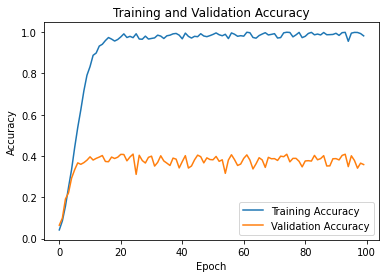

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

file_path = r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\merged_df.csv"

# Load the dataset
merged_df = pd.read_csv(file_path)

# Sample the dataset
merged_df = merged_df.sample(n=10000, random_state=42)

# Drop specified columns
columns_to_drop = ['Worker_ID', 'predicted', 'Ethnicity', 'Officer_Type']
merged_df.drop(columns=columns_to_drop, inplace=True)

# Fill missing values with -1
merged_df.fillna(value=-1, inplace=True)

target = 'OEWS_Code_1'

X = merged_df.drop(columns=[target])  # Features
y = merged_df[target]

# Separate categorical and continuous features
categorical_features = [col for col in X.columns if col != 'payment_amount']
continuous_features = ['payment_amount']

# One-hot encode categorical features
encoder = OneHotEncoder(drop='first', sparse=False)
X_categorical = encoder.fit_transform(X[categorical_features])

# Combine one-hot encoded features with continuous features
X_encoded = pd.concat([pd.DataFrame(X_categorical), X[continuous_features].reset_index(drop=True)], axis=1)

# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2)

# Build the neural network model
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Output layer with softmax activation for multi-class classification

learning_rate = 0.001  # Choose your desired learning rate

# Create the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Plot training accuracy over iterations
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


C:\Users\ahmad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\ahmad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\ahmad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\ahmad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. 

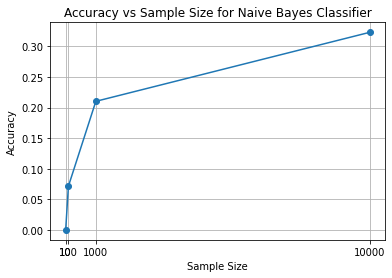

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

file_path = r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\merged_df.csv"

# Load the dataset
merged_df = pd.read_csv(file_path)

# Define sample sizes
sample_sizes = [10, 100, 1000, 10000]
accuracies = []

for sample_size in sample_sizes:
    # Sample the dataset
    sampled_df = merged_df.sample(n=sample_size, random_state=42)

    # Drop specified columns and 'Worker_ID'
    columns_to_drop = ['Worker_ID', 'predicted', 'Gender', 'Ethnicity', 'Officer_Type']
    sampled_df.drop(columns=columns_to_drop, axis=1, inplace=True)

    # Drop NaN values
    sampled_df.dropna(inplace=True)

    # Define features (X) and target (y)
    X = sampled_df.drop('OEWS_Code_1', axis=1)
    y = sampled_df['OEWS_Code_1']

    # Separate categorical and continuous features
    categorical_features = [col for col in X.columns if col != 'payment_amount']
    continuous_features = ['payment_amount']

    # Convert categorical features to strings
    X[categorical_features] = X[categorical_features].astype(str)

    # One-hot encode categorical features
    encoder = OneHotEncoder(drop='first', sparse=False)
    X_categorical = encoder.fit_transform(X[categorical_features])

    # Combine one-hot encoded features with continuous features
    X_encoded = pd.concat([pd.DataFrame(X_categorical), X[continuous_features].reset_index(drop=True)], axis=1)

    # Convert to arrays to drop feature names
    X_encoded_array = X_encoded.values
    y_array = y.values

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_encoded_array, y_array, test_size=0.2, random_state=42)

    # Initialize the Naive Bayes Classifier model (Gaussian Naive Bayes)
    nb_model = GaussianNB()

    # Fit the model on the training data
    nb_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = nb_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plot accuracies
plt.plot(sample_sizes, accuracies, marker='o')
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Sample Size for Naive Bayes Classifier')
plt.xticks(sample_sizes)
plt.grid(True)
plt.show()


In [2]:
accuracies

[0.0, 0.07142857142857142, 0.21014492753623187, 0.3230437903804738]

C:\Users\ahmad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\ahmad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\ahmad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\ahmad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. 

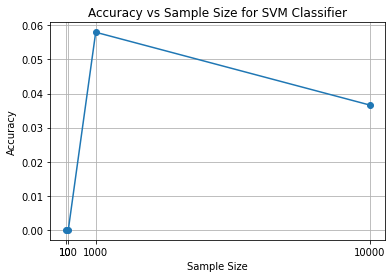

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

file_path = r"C:\Users\ahmad\Desktop\Team_07_Paychex-selected\merged_df.csv"

# Load the dataset
merged_df = pd.read_csv(file_path)

# Define sample sizes
sample_sizes = [10, 100, 1000, 10000]
accuracies = []

for sample_size in sample_sizes:
    # Sample the dataset
    sampled_df = merged_df.sample(n=sample_size, random_state=42)

    # Drop specified columns and 'Worker_ID'
    columns_to_drop = ['Worker_ID', 'predicted', 'Gender', 'Ethnicity', 'Officer_Type']
    sampled_df.drop(columns=columns_to_drop, axis=1, inplace=True)

    # Drop NaN values
    sampled_df.dropna(inplace=True)

    # Define features (X) and target (y)
    X = sampled_df.drop('OEWS_Code_1', axis=1)
    y = sampled_df['OEWS_Code_1']

    # Separate categorical and continuous features
    categorical_features = [col for col in X.columns if col != 'payment_amount']
    continuous_features = ['payment_amount']

    # Convert categorical features to strings
    X[categorical_features] = X[categorical_features].astype(str)

    # One-hot encode categorical features
    encoder = OneHotEncoder(drop='first', sparse=False)
    X_categorical = encoder.fit_transform(X[categorical_features])

    # Combine one-hot encoded features with continuous features
    X_encoded = pd.concat([pd.DataFrame(X_categorical), X[continuous_features].reset_index(drop=True)], axis=1)

    # Convert to arrays to drop feature names
    X_encoded_array = X_encoded.values
    y_array = y.values

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_encoded_array, y_array, test_size=0.2, random_state=42)

    # Initialize the SVM Classifier model
    svm_model = SVC(kernel='rbf', random_state=42)

    # Fit the model on the training data
    svm_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = svm_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plot accuracies
plt.plot(sample_sizes, accuracies, marker='o')
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Sample Size for SVM Classifier')
plt.xticks(sample_sizes)
plt.grid(True)
plt.show()


In [4]:
accuracies

[0.0, 0.0, 0.057971014492753624, 0.0366116295764537]